# Min Cost + Div30

In [1]:
import swolfpy as sp
import swolfpy_inputdata as spid
import swolfpy_processmodels as sppm

import brightway2 as bw2
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import datetime
import os
import platform
from IPython.display import Image

# Set font for plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "14"

# Set specs for pandas
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.set_option("precision", 2)

### SwolfPy version used to produced the results:

In [2]:
pd.DataFrame({'Version': [sp.__version__, sppm.__version__, spid.__version__]},
             index=['swolfpy', 'swolfpy_processmodels', 'swolfpy_inputdata'])

,Version
swolfpy,0.2.4
swolfpy_processmodels,0.1.9
swolfpy_inputdata,0.2.4


### System info

In [3]:
pd.DataFrame({'info': [platform.platform(),
                       platform.processor(),
                       os.cpu_count()]},
             index=['Platform', 'Processor', 'CPU_count'])

,info
Platform,Windows-10-10.0.19041-SP0
Processor,"Intel64 Family 6 Model 158 Stepping 9, GenuineIntel"
CPU_count,8


## Setup

In [4]:
iter_mehtod = 'LHS' 
n_iter = 50
n_proc = os.cpu_count()
timeout = 400

method = ('SwolfPy_Total_Cost', 'SwolfPy')

TotCost_Method = ('SwolfPy_Total_Cost', 'SwolfPy')
OptCost_Method = ('SwolfPy_Operational_Cost', 'SwolfPy')
CapCost_Method = ('SwolfPy_Capital_Cost', 'SwolfPy')
GWP_Method = ('IPCC 2013, Ecoinvent V3.5', 'climate change', 'GWP 100a, bioCO2=1, C1_36')
CED_Method = ('cumulative energy demand', 'fossil', 'non-renewable energy resources, fossil')
ACID_Method = ('TRACI (2.1) SwolfPy', 'environmental impact', 'acidification')
ETP_Method = ('TRACI (2.1) SwolfPy', 'environmental impact', 'eutrophication')
SMOG_Method = ('TRACI (2.1) SwolfPy', 'environmental impact', 'photochemical smog')
ETOX_Method = ('USEtox (obsolete)', 'ecotoxicity', 'total')
HTOX_Method = ('USEtox (obsolete)', 'human toxicity', 'total')

summary = f"""
********  Config *********
Time: {datetime.datetime.now().strftime("%Y-%m-%d & %H:%M:%S")}
Initial guess generation: {iter_mehtod}
N iter: {n_iter}
N proc: {n_proc}
timeout: {timeout}\n
"""
text_file = open("Summary.txt", "a")
text_file.write(summary)
text_file.close()

## Create project

In [5]:
project_name = 'optimization'
technosphere = sp.Technosphere(project_name)
common_data = spid.CommonData()
ProcessMetaData = sppm.ProcessModelsMetaData.ProcessModelsMetaData

In [6]:
# Treatment processes
Treatment_processes = {}
Treatment_processes['LF'] = {'input_type':ProcessMetaData['LF']['InputType'] , 'model':sppm.LF()}
Treatment_processes['Composting'] = {'input_type':ProcessMetaData['Comp']['InputType'] , 'model':sppm.Comp()}
Treatment_processes['AD'] = {'input_type':ProcessMetaData['AD']['InputType'] , 'model':sppm.AD()}
Treatment_processes['AnF'] = {'input_type':ProcessMetaData['AnF']['InputType'] , 'model':sppm.AnF()}
Treatment_processes['SS_MRF'] = {'input_type':ProcessMetaData['SS_MRF']['InputType'] , 'model':sppm.SS_MRF()}
Treatment_processes['Reprocessing'] = {'input_type':ProcessMetaData['Reproc']['InputType'] , 'model':sppm.Reproc()}
#Treatment_processes['RDF'] = {'input_type':ProcessMetaData['RDF']['InputType'] , 'model':sppm.RDF()}
#Treatment_processes['GC'] = {'input_type':ProcessMetaData['GC']['InputType'] , 'model':sppm.GC()}
#Treatment_processes['WTE'] = {'input_type':ProcessMetaData['WTE']['InputType'] , 'model':sppm.WTE()}
Treatment_processes['Reprocessing'] = {'input_type':ProcessMetaData['Reproc']['InputType'] , 'model':sppm.Reproc()}

In [7]:
# Distance
#Processes = ['LF', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing', 'RDF', 'GC', 'WTE', 'SF', 'MF', 'COM']
Processes = ['LF', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing', 'SF', 'MF', 'COM']
data = sppm.Distance.create_distance_table(process_names=Processes,
                                           transport_modes=['Heavy Duty Truck'],
                                           default_dist=30)

distance = sppm.Distance(data)          
data['Heavy Duty Truck']

,LF,Composting,AD,AnF,SS_MRF,Reprocessing,SF,MF,COM
LF,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
Composting,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0
AD,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0
AnF,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0
SS_MRF,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0
Reprocessing,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0
SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0
MF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
COM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Collection_processes:
Collection_processes = {}

SF_scheme = sppm.SF_Col.scheme()
SF_scheme[('RWC', 'SSO', 'SSR')] = 0.333
SF_scheme[('RWC', 'SSYW', 'SSR')] = 0.334
SF_scheme[('RWC', 'N/A', 'SSR')] = 0.333
Collection_processes['SF'] = {'input_type': [],
                              'model': sppm.SF_Col('SF', SF_scheme,
                              Treatment_processes=Treatment_processes,
                              Distance=distance)}

MF_scheme = sppm.MF_Col.scheme()
MF_scheme[('RWC', 'SSO', 'SSR')] = 0.333
MF_scheme[('RWC', 'SSYW', 'SSR')] = 0.334
MF_scheme[('RWC', 'N/A', 'SSR')] = 0.333
Collection_processes['MF'] = {'input_type': [],
                              'model': sppm.MF_Col('MF', MF_scheme,
                              Treatment_processes=Treatment_processes,
                              Distance=distance)}

COM_scheme = sppm.COM_Col.scheme()
COM_scheme[('RWC', 'N/A', 'SSR')] = 0.25
COM_scheme[('RWC', 'SSYW', 'SSR')] = 0.25
COM_scheme[('RWC', 'SSO', 'SSR')] = 0.25
COM_scheme[('RWC', 'SSO_AnF', 'SSR')] = 0.25
Collection_processes['COM'] = {'input_type': [],
                               'model': sppm.COM_Col('COM', COM_scheme,
                               Treatment_processes=Treatment_processes,
                               Distance=distance)}

In [9]:
population = 10**6
SF_density = 2.66
MF_density = 2.06
MF_fraction = 0.25
res_gen_rate = 1.12

# Composition data
comp_data = pd.read_csv('Composition Data/Updated Composition.csv', index_col=0)

# Set SF
Collection_processes['SF']['model'].process_data['Comp'] = comp_data['SingleFamily'].values
Collection_processes['SF']['model'].InputData.Col['res_per_dwel']['amount'] = SF_density
Collection_processes['SF']['model'].InputData.Col['houses_res']['amount'] = population * (1-MF_fraction) / SF_density
Collection_processes['SF']['model'].InputData.Col['res_gen']['amount'] = res_gen_rate

# Set MF
Collection_processes['MF']['model'].process_data['Comp'] = comp_data['MultiFamily'].values
Collection_processes['MF']['model'].InputData.Col['res_per_dwel']['amount'] = MF_density
Collection_processes['MF']['model'].InputData.Col['houses_res']['amount'] = population * MF_fraction / MF_density
Collection_processes['MF']['model'].InputData.Col['res_gen']['amount'] = res_gen_rate

# Set COM
Collection_processes['COM']['model'].process_data['Comp'] = comp_data['Restaurants'].values
Mass_Restaurants = 0.0549 * population - 2304.8
N_locations = 1000
Collection_processes['COM']['model'].InputData.Col['comm_gen']['amount'] = Mass_Restaurants / N_locations / (365/7) * 1000
Collection_processes['COM']['model'].InputData.Col['comm_loc']['amount'] = N_locations

In [10]:
start = time()
demo = sp.Project(project_name, common_data, Treatment_processes, distance, Collection_processes, technosphere)
demo.init_project()
demo.write_project()
demo.group_exchanges()
print("Time for writing the project: {} second".format(round(time()-start)))

Biosphere database already present!!! No setup is needed
Vacuuming database 
Vacuuming database 
Vacuuming database 


Writing activities to SQLite3 database:



                ####
                ++++++  Writing the Technosphere
                


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:25
  Finished: 02/10/2022 00:52:40
  Total time elapsed: 00:00:15
  CPU %: 47.80
  Memory %: 1.36


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:41
  Finished: 02/10/2022 00:52:41
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.37

              ####
              ++++++ Initializing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:41
  Finished: 02/10/2022 00:52:41
  Total time elapsed: 00:00:00
  CPU %: 100.80
  Memory %: 1.37


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the AD
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:41
  Finished: 02/10/2022 00:52:42
  Total time elapsed: 00:00:00
  CPU %: 208.30
  Memory %: 1.37

              ####
              ++++++ Initializing the AnF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:42
  Finished: 02/10/2022 00:52:42
  Total time elapsed: 00:00:00
  CPU %: 146.50
  Memory %: 1.37

              ####
              ++++++ Initializing the SS_MRF
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:42
  Finished: 02/10/2022 00:52:42
  Total time elapsed: 00:00:00
  CPU %: 195.30
  Memory %: 1.37

              ####
              ++++++ Initializing the Reprocessing
              

Writing activities to SQLite3 database:


0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:42
  Finished: 02/10/2022 00:52:42
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.37

              ####
              ++++++ Initializing the SF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:42
  Finished: 02/10/2022 00:52:42
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.37


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the MF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:42
  Finished: 02/10/2022 00:52:42
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.37


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the COM
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:42
  Finished: 02/10/2022 00:52:42
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 1.37


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:42
  Finished: 02/10/2022 00:52:44
  Total time elapsed: 00:00:01
  CPU %: 43.00
  Memory %: 1.38


Writing activities to SQLite3 database:



                  ####
                  ++++++ Writing the Composting_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:44
  Finished: 02/10/2022 00:52:44
  Total time elapsed: 00:00:00
  CPU %: 166.20
  Memory %: 1.39

              ####
              ++++++ Writing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:44
  Finished: 02/10/2022 00:52:44
  Total time elapsed: 00:00:00
  CPU %: 85.60
  Memory %: 1.39

                  ####
                  ++++++ Writing the AD_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:44
  Finished: 02/10/2022 00:52:44
  Total time elapsed: 00:00:00
  CPU %: 140.20
  Memory %: 1.40

              ####
              ++++++ Writing the AD
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:45
  Finished: 02/10/2022 00:52:45
  Total time elapsed: 00:00:00
  CPU %: 56.40
  Memory %: 1.40

                  ####
                  ++++++ Writing the AnF_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:45
  Finished: 02/10/2022 00:52:45
  Total time elapsed: 00:00:00
  CPU %: 100.80
  Memory %: 1.40


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the AnF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:45
  Finished: 02/10/2022 00:52:45
  Total time elapsed: 00:00:00
  CPU %: 140.20
  Memory %: 1.41

                  ####
                  ++++++ Writing the SS_MRF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:46
  Finished: 02/10/2022 00:52:46
  Total time elapsed: 00:00:00
  CPU %: 42.10
  Memory %: 1.42


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the SS_MRF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:47
  Finished: 02/10/2022 00:52:47
  Total time elapsed: 00:00:00
  CPU %: 81.80
  Memory %: 1.43

              ####
              ++++++ Writing the Reprocessing
              


0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:47
  Finished: 02/10/2022 00:52:47
  Total time elapsed: 00:00:00
  CPU %: 40.10
  Memory %: 1.43

                  ####
                  ++++++ Writing the SF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:47
  Finished: 02/10/2022 00:52:48
  Total time elapsed: 00:00:00
  CPU %: 69.30
  Memory %: 1.43


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the SF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:48
  Finished: 02/10/2022 00:52:48
  Total time elapsed: 00:00:00
  CPU %: 127.80
  Memory %: 1.44

                  ####
                  ++++++ Writing the MF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:49
  Finished: 02/10/2022 00:52:49
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 1.44


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the MF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:50
  Finished: 02/10/2022 00:52:50
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 1.45

                  ####
                  ++++++ Writing the COM_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:50
  Finished: 02/10/2022 00:52:50
  Total time elapsed: 00:00:00
  CPU %: 63.60
  Memory %: 1.45


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the COM
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2022 00:52:51
  Finished: 02/10/2022 00:52:51
  Total time elapsed: 00:00:00
  CPU %: 87.50
  Memory %: 1.45

                  Grouping the exchanges with parameters in Database LF
                  

                  Grouping the exchanges with parameters in Database Composting
                  

                  Grouping the exchanges with parameters in Database AD
                  

                  Grouping the exchanges with parameters in Database AnF
                  

                  Grouping the exchanges with parameters in Database SS_MRF
                  

                  Grouping the exchanges with parameters in Database Reprocessing
                  

                  Grouping the exchanges with parameters in Database SF
                  

                  Grouping the exchanges with parameters in Database MF
                  

                  Grouping the exchanges with parameters in Databas

In [11]:
start = time()
demo.update_parameters(demo.parameters.default_parameters_list())
print("Time for updating the parameters: {} second".format(round(time()-start)))
demo.parameters_list

Time for updating the parameters: 6 second


[{'name': 'frac_of_SSO_from_SF_to_Composting', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_SF_to_AD', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_MF_to_Composting', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_MF_to_AD', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_COM_to_Composting', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_COM_to_AD', 'amount': 0.5}]

In [12]:
input_dict = {'SF':{}, 'MF':{}, 'COM':{}}

for key in common_data.Index:
    input_dict['SF'][key] = 1
    input_dict['MF'][key] = 1
    input_dict['COM'][key] = 1

demo.create_scenario(input_dict, 'Collection')

In [13]:
FU=bw2.get_activity(('waste', 'Collection'))

## Mass flows, impacts and costs based on default parameters

In [14]:
process_list = ['SF', 'MF', 'COM', 'LF', 'WTE', 'RDF', 'GC', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing']
perform_index = ['Diversion', 'GWP', 'Operation Cost', 'Capital cost', 'Total cost',
                 'CED', 'Acidification', 'Eutrophication', 'Photochemical smog',
                 'Ecotoxicity', 'Human toxicity']
results = pd.DataFrame(columns=['Value', 'Unit'],
                       index=perform_index+process_list,)

bw2.projects.set_current('optimization')
Demand = {('waste', 'Collection'):1}
FU=bw2.get_activity(('waste', 'Collection'))
lca=bw2.LCA(Demand, GWP_Method)
lca.lci()
lca.lcia()
results.loc['GWP',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg CO2 eq/Mg']

lca.switch_method(OptCost_Method)
lca.lcia()
results.loc['Operation Cost',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']


lca.switch_method(CapCost_Method)
lca.lcia()
results.loc['Capital cost',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

lca.switch_method(TotCost_Method)
lca.lcia()
results.loc['Total cost',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

lca.switch_method(CED_Method)
lca.lcia()
results.loc['CED',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'MJ eq/Mg']

lca.switch_method(ACID_Method)
lca.lcia()
results.loc['Acidification',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg SO2 eq/Mg']

lca.switch_method(ETP_Method)
lca.lcia()
results.loc['Eutrophication',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg N eq/Mg']

lca.switch_method(SMOG_Method)
lca.lcia()
results.loc['Photochemical smog',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg O3 eq/Mg']

lca.switch_method(ETOX_Method)
lca.lcia()
results.loc['Ecotoxicity',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']

lca.switch_method(HTOX_Method)
lca.lcia()
results.loc['Human toxicity',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']


for process in process_list:
    results.loc[process,:] = [round(sp.LCA_matrix.LCA_matrix.get_mass_flow(lca, process)), 'Mg/yr']

results.loc['Diversion',:] = [(1 - results['Value']['LF'] / float(FU.as_dict()['unit'].split(' ')[0])) * 100, '%']
results

,Value,Unit
Diversion,34.85,%
GWP,466.65,kg CO2 eq/Mg
Operation Cost,45.45,$/Mg
Capital cost,4.87,$/Mg
Total cost,50.32,$/Mg
CED,-3759.64,MJ eq/Mg
Acidification,-2.67,kg SO2 eq/Mg
Eutrophication,-0.21,kg N eq/Mg
Photochemical smog,-9.82,kg O3 eq/Mg
Ecotoxicity,-4687.44,CTU/Mg


In [15]:
demo.parameters_list

[{'name': 'frac_of_SSO_from_SF_to_Composting', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_SF_to_AD', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_MF_to_Composting', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_MF_to_AD', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_COM_to_Composting', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_COM_to_AD', 'amount': 0.5}]

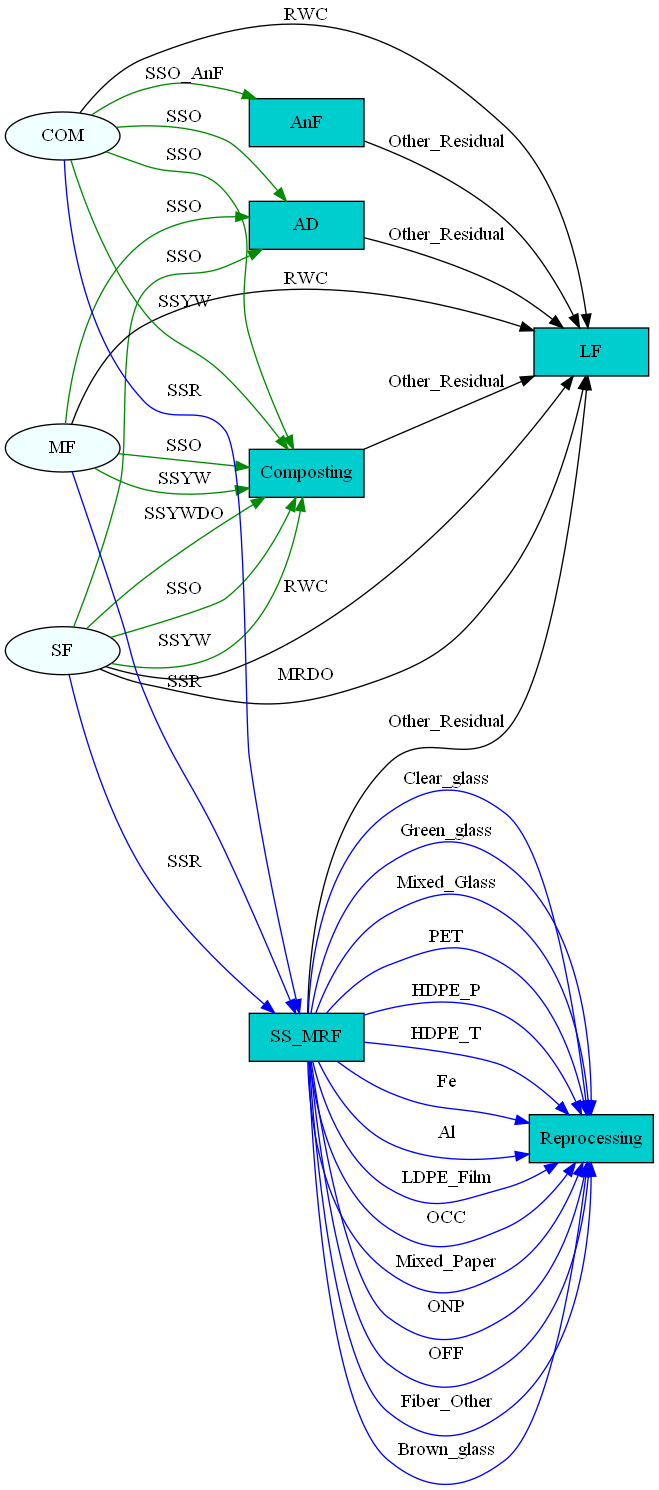

In [16]:
demo.parameters.SWM_network(show_vals=False, all_flow=False, filename='SWM_network_optimization')
Image(filename='SWM_network_optimization.gv.png', width=300)

In [17]:
# Functions used in reporting the optimization results
def Iterations_Performance(OptObject, FileName):
    objectives = []
    times = []
    for res in OptObject.all_results:
        if res:
            if res.success:
                objectives.append(res.fun * 10**OptObject.magnitude)
                times.append(res.time)
            else:
                objectives.append(None)
                times.append(res.time)
        else:
            objectives.append(None)
            times.append(None)

    DF = pd.DataFrame({'Objective': objectives, 'Time': times})
    DF['Ratio'] = DF['Objective']/DF['Objective'].min()
    DF.to_csv(FileName)

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "14"
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15,9), sharex=True)

    DF['Objective'].plot(kind='bar', ax=ax1, color='b')
    ax1.set_ylabel(Opt.method[0][-1])

    DF['Ratio'].plot(kind='bar', ax=ax2, color='r')
    ax2.set_ylabel('Ratio to minimum')

    DF['Time'].plot(kind='bar', ax=ax3, color='g')
    ax3.set_ylabel("Time (sec)")
    ax3.set_xlabel('Iteration')
    
    if len(list(DF.index)) > 20:
        ax3.set_xticks(list(DF.index[::5]))
        ax3.set_xticklabels(list(DF.index)[::5])
    
    return DF

def report_res(Opt, FU, fileName):
    results = pd.DataFrame(columns=['Value', 'Unit'],
                           index=perform_index+process_list,)
    Opt.switch_method(GWP_Method)
    Opt.lcia()
    results.loc['GWP',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg CO2/Mg']

    Opt.switch_method(OptCost_Method)
    Opt.lcia()
    results.loc['Operation Cost',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

    Opt.switch_method(CapCost_Method)
    Opt.lcia()
    results.loc['Capital cost',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

    Opt.switch_method(TotCost_Method)
    Opt.lcia()
    results.loc['Total cost',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

    Opt.switch_method(CED_Method)
    Opt.lcia()
    results.loc['CED',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'MJ eq/Mg']

    Opt.switch_method(ACID_Method)
    Opt.lcia()
    results.loc['Acidification',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg SO2 eq/Mg']

    Opt.switch_method(ETP_Method)
    Opt.lcia()
    results.loc['Eutrophication',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg N eq/Mg']

    Opt.switch_method(SMOG_Method)
    Opt.lcia()
    results.loc['Photochemical smog',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg O3 eq/Mg']

    Opt.switch_method(ETOX_Method)
    Opt.lcia()
    results.loc['Ecotoxicity',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']

    Opt.switch_method(HTOX_Method)
    Opt.lcia()
    results.loc['Human toxicity',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']


    for process in process_list:
        results.loc[process,:] = [round(sp.LCA_matrix.LCA_matrix.get_mass_flow(Opt, process)), 'Mg/yr']

    results.loc['Diversion',:] = [(1 - results['Value']['LF'] / float(FU.as_dict()['unit'].split(' ')[0])) * 100, '%']
    
    results.to_csv(fileName)
    return(results)

# Optimization

In [18]:
scenario_name = 'MinCost-Div30'
Opt=sp.Optimization(Demand,[method], demo)

constraints = {}
constraints['LF'] = {'limit':float(FU.as_dict()['unit'].split(' ')[0]) * 0.7, 'KeyType':'Process','ConstType':"<="}

config=Opt.config(demo)
config.iloc[6:, [1, 3, 5]] = 'Fix'
config.iloc[6:8, [5]] = 'Optimize'

# Force Separate collection of Recyclables
for s in config.index:
    if s[2] == 'N/A':
        config.loc[[s], ['SF', 'MF', 'COM']] = 0
        config.loc[[s], ['SF mode', 'MF mode', 'COM mode']] = 'Fix'

# Force Separate collection of organics
# for s in config.index:
#     if s[1] == 'N/A' or s[1] == 'SSYW':
#         config.loc[[s], ['SF', 'MF', 'COM']] = 0
#         config.loc[[s], ['SF mode', 'MF mode', 'COM mode']] = 'Fix'
           
           
Opt.set_config(config)
config

,SF,SF mode,MF,MF mode,COM,COM mode
"(RWC, N/A, N/A)",0.00,Fix,0.00,Fix,0.00,Fix
"(RWC, N/A, SSR)",0.33,Optimize,0.33,Optimize,0.25,Optimize
"(RWC, SSYW, N/A)",0.00,Fix,0.00,Fix,0.00,Fix
"(RWC, SSYW, SSR)",0.33,Optimize,0.33,Optimize,0.25,Optimize
"(RWC, SSO, N/A)",0.00,Fix,0.00,Fix,0.00,Fix
"(RWC, SSO, SSR)",0.33,Optimize,0.33,Optimize,0.25,Optimize
"(RWC, SSO_AnF, N/A)",0.00,Fix,0.00,Fix,0.00,Fix
"(RWC, SSO_AnF, SSR)",0.00,Fix,0.00,Fix,0.25,Optimize
"(REC_WetRes, N/A, REC_WetRes)",0.00,Fix,0.00,Fix,0.00,Fix
"(REC_WetRes, SSYW, REC_WetRes)",0.00,Fix,0.00,Fix,0.00,Fix


In [19]:
start = time()
sp.Optimization.multi_start_optimization(Opt, constraints=constraints, collection=True,
                                         n_iter=n_iter, nproc=n_proc, timeout=timeout, initialize_guess=iter_mehtod)
total_time = round(time()-start)
print("Time for Optimization: {} second".format(total_time))
all_results = Opt.all_results



                      Iteration: 0
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 15735853.492424551
                      Global min: 15735853.492424551 

                      


                      Iteration: 1
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 15754274.719855363
                      Global min: 15735853.492424551 

                      


                      Iteration: 2
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 15735854.330483109
                      Global min: 15735853.492424551 

                      


                      Iteration: 3
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 15735853.492392892
                      Global min: 15735853.492

Time for Optimization: 1605 second


### Performance of iterations

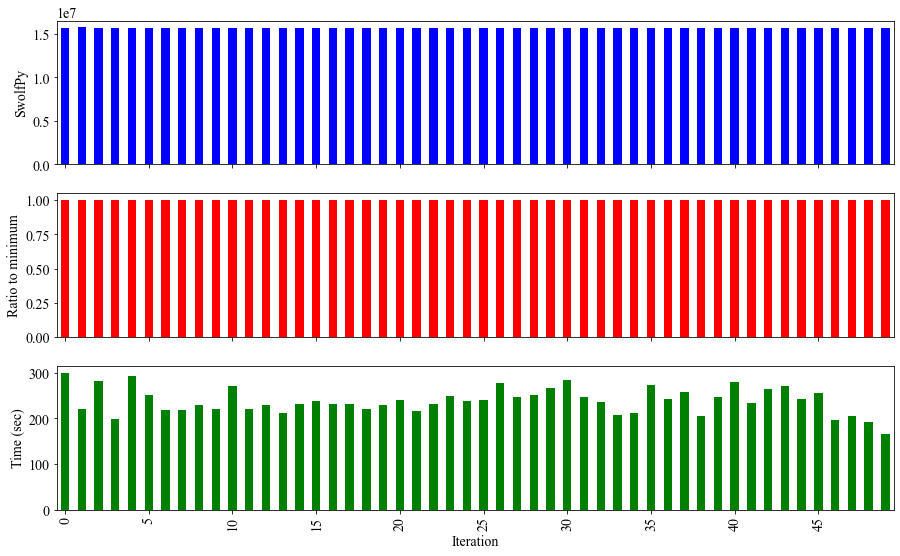

In [20]:
DF = Iterations_Performance(Opt, f'{scenario_name}_Iterations.csv')

## Mass flows, impacts and costs

In [21]:
report_res(Opt, FU, f'{scenario_name}.csv')

,Value,Unit
Diversion,30.0,%
GWP,424.41,kg CO2/Mg
Operation Cost,31.06,$/Mg
Capital cost,3.04,$/Mg
Total cost,34.1,$/Mg
CED,-3714.33,MJ eq/Mg
Acidification,-2.87,kg SO2 eq/Mg
Eutrophication,-0.48,kg N eq/Mg
Photochemical smog,-13.05,kg O3 eq/Mg
Ecotoxicity,-0.0,CTU/Mg


In [22]:
Opt.switch_method(method)
Opt.lcia()
Opt.plot_sankey(fileName=f'{scenario_name}.html')


              # Sankey Mass flows
              label = ['LF', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing', 'SF', 'MF', 'COM']
              source = [6, 6, 7, 7, 8, 8, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8]
              target = [1, 2, 1, 2, 1, 2, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 4, 1, 0, 1, 0, 4, 1, 0, 4, 1, 3]
              label_link = ['SSO', 'SSO', 'SSO', 'SSO', 'SSO', 'SSO', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'LDPE_Film', 'OCC', 'Mixed_Paper', 'ONP', 'OFF', 'Fiber_Other', 'Brown_glass', 'Clear_glass', 'Green_glass', 'Mixed_Glass', 'PET', 'HDPE_P', 'HDPE_T', 'Fe', 'Al', 'RWC', 'SSR', 'SSYW', 'MRDO', 'SSYWDO', 'RWC', 'SSR', 'SSYW', 'RWC', 'SSR', 'SSYW', 'SSO_AnF']
              value = [4657.566, 0.0, 16265.562, 0.0, 0.0, 0.0, 391.735, 0.0, 998.433, 16090.048, 3204.139, 33335.462, 45750.699, 0.0, 0.0, 0.0, 1839.473, 1946.923, 1826.578, 0.0, 3009.381, 773.

In [23]:
params_df = pd.DataFrame(Opt.optimized_x)
for i, j in params_df['name'].items():
    if type(j) == str:
        j = j.strip('frac_of_')
        params_df.loc[i, 'From'] = j.split('_from_')[1].split('_to_')[0]
        params_df.loc[i, 'To'] = j.split('_from_')[1].split('_to_')[1]
        params_df.loc[i, 'Product'] = j.split('_from_')[0]
    else:
        params_df.loc[i, 'From'] = j[0]
        params_df.loc[i, 'Product'] = str(j[1])
params_df[['From', 'To', 'Product', 'amount']]

,From,To,Product,amount
0,SF,Composting,SSO,1.00
1,SF,AD,SSO,0.00
2,MF,Composting,SSO,1.00
3,MF,AD,SSO,0.00
4,COM,Composting,SSO,0.69
5,COM,AD,SSO,0.31
6,SF,NaN,"('RWC', 'N/A', 'SSR')",0.95
7,SF,NaN,"('RWC', 'SSYW', 'SSR')",0.00
8,SF,NaN,"('RWC', 'SSO', 'SSR')",0.05
9,MF,NaN,"('RWC', 'N/A', 'SSR')",0.00


In [24]:
summary = f"""\n
********  {scenario_name} - Summary *********
Number of decision variables: {len(Opt.optimized_x)}
Number of constraints: {len(Opt._create_constraints())}
Total time: {str(datetime.timedelta(seconds=round(total_time)))}
Average time per iteration: {str(datetime.timedelta(seconds=round(DF['Time'].mean())))}
Successful iterations: {sum(DF['Ratio']>0)}
Number of best iterations: {sum(DF['Ratio']>0.99)}
Number of >95 iterations: {sum(DF['Ratio']>0.95)}\n\n"""
print(summary)
text_file = open("Summary.txt", "a")
text_file.write(summary)
text_file.close()



 collection constraints dict: 
 {'SF': [6, 7, 8], 'MF': [9, 10, 11], 'COM': [12, 13, 14, 15]} 




********  MinCost-Div30 - Summary *********
Number of decision variables: 16
Number of constraints: 7
Total time: 0:26:45
Average time per iteration: 0:03:58
Successful iterations: 50
Number of best iterations: 50
Number of >95 iterations: 50




## Improve/Revise solution

In [25]:
# xx = [x['amount'] for x in Opt.optimized_x]
# xx[36] = 0
# Opt.optimized_x[36]['amount'] = 0
# xx[39] = 1
# Opt.optimized_x[39]['amount'] = 1
# Opt.switch_method(method)
# Opt.lcia()

# new_res = Opt._objective_function(xx) * 10**Opt.magnitude
# opt_solution = Opt.res_global['fun'] * 10**Opt.magnitude
# ratio = round(new_res/opt_solution, 5)
# solution_improved = new_res<opt_solution

# print(new_res, new_res<opt_solution, ratio)

In [26]:
# report_res(Opt, FU, f'{scenario_name}.csv')

In [27]:
# Opt.optimized_x

In [28]:
# Opt.switch_method(method)
# Opt.lcia()
# Opt.plot_sankey(optimized_flow=False, show=True, fileName=f'{scenario_name}.html', params=xx)